# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

# Itertools
from itertools import product

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

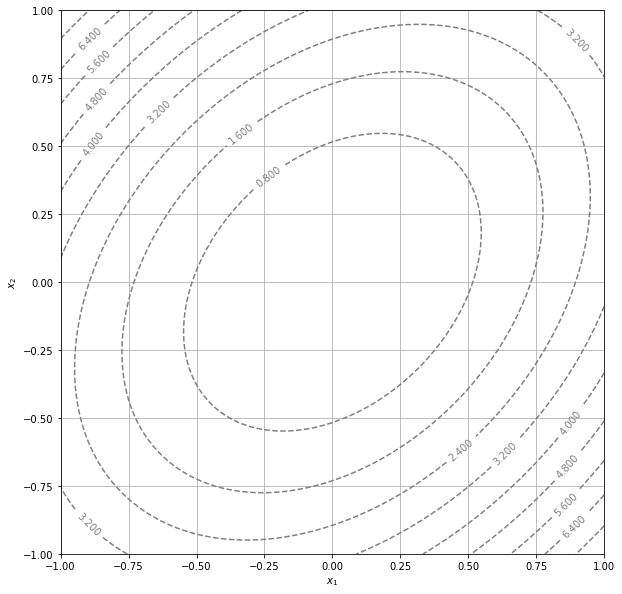

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

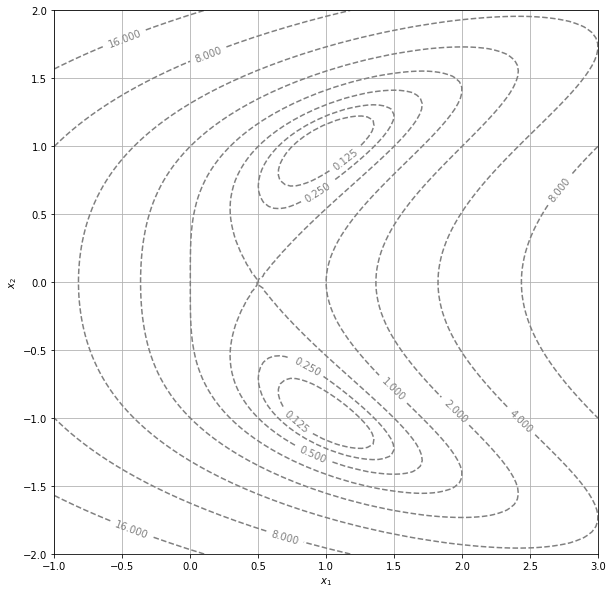

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

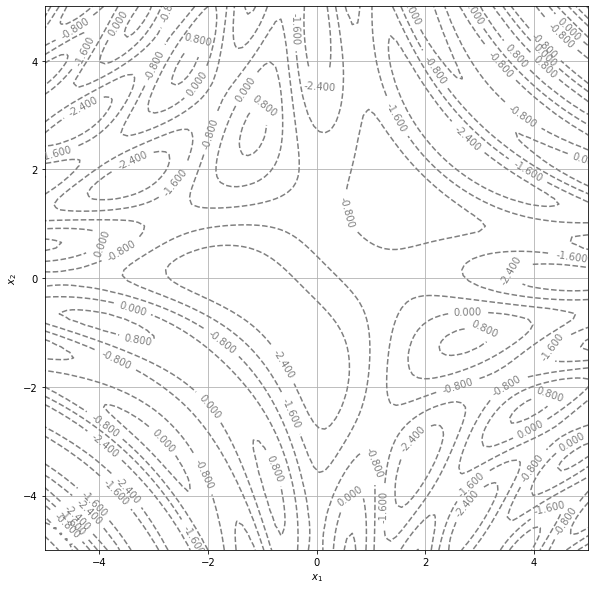

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

**Réponse :** 

Soit $A$ l'ensemble de niveau c de $f$ : $A$ = {$(x_1, x_2) f(x_1, x_2) = c$}.

Premièrement, $A$ est fermé en tant qu'ensemble de niveau : c'est $f^{-1}(\{c\})$ avec $\{c\}$ qui est un singleton, donc fermé. 

Deuxièmement, A est borné car la fonction $f$ tend vers $+\infty$ quand $\|(x_1, x_2)\|\rightarrow +\infty$. Donc $A$ est un fermé, borné en dimension finie.

L'ensemble de niveau c de $f$ est donc un compact.



Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

**Réponse :**
    
La fonction $p$ appliquée à $x$ est le produit vectoriel entre $\frac {\nabla f(x_0)}{||\nabla f(x_0)||}$ et $(x - x_0)$, où $x = (x_1, x_2)$.


La fonction $p$ détermine la projection de $(x - x_0)$ orthogonalement au gradient de $f$ en $x_0$ car ce vecteur est une rotation d'angle -$\frac{\pi}{2}$ du gradient de $f$ en $x_0$. Elle s'annule si et seulement si  $(x-x_0)$ est colinéaire à $\nabla f(x_0)$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

**Réponse :**

On introduit

$\hat{f}:(x, p(x))\mapsto (f(x) - c, p(x) - t)$ où $c=f(x_0)$


On a  $\partial_x\hat{f} = (\nabla f, \nabla p(x))$
 
Or $\nabla f$ est non nulle sur un voisinage de $x_0$ (hypothèse) donc $\partial_x\hat{f}$ ne s'annule pas sur un voisinage de $(x_0, t_0)$ avec $(x_0, t_0)$ un point d'annulation de $\hat{f}$.

Par le théorème des fonctions implicites, on a l'existence de $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ continûment différentiable et telle que :
$\hat{f}(x, p(x)) = 0 \Leftrightarrow x = \gamma(p(x))$ (on a bien le $x_0$)
Soit encore $f(x_1, x_2) = c$ si et seulement si $(x_1, x_2) = \gamma\circ p(x_1, x_2)$


#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

**Réponse :**

D'après le cours (théorème des fonctions implicites), on a 
$\gamma'(t)  = -(\partial_x\hat{f}(x, t))^{-1}\cdot\partial_t\hat{f}(x, t)$

On a $\partial_x\hat{f}\neq 0$ d'après la question précédente. 

Or $\partial_t\hat{f} =(0, -1)\neq 0$

Conclusion : $\gamma'$ ne s'annule pas


Montrons à présent que $<\nabla f\circ\gamma(t) | \gamma'(t)> =0$

On a : $\nabla p (x_1, x_2) = \frac 1 {||\nabla f(x_0)||}(\partial_2f(x_0), -\partial_1f(x_0))$

Donc $\gamma'(t) = - (\nabla f(x), \nabla p(x))^{-1}\cdot(0, -1) = +(\nabla p(x))^{-1}$

De plus, $\nabla f\circ\gamma(t) =\gamma'(t)\cdot\nabla f(\gamma (t))$

Ainsi, 


$<\nabla (f\circ\gamma)(t) | \gamma'(t)> = < \gamma'(t)\cdot\nabla f(\gamma (t))|\gamma(t)>$



## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 10**(-6)

**Réponse :**

La méthode de Newton, dans les cas où elle converge (fonction localement monotone), converge très vite vers la bonne valeur. On peut donc prendre un $\epsilon$ assez petit sans trop de problèmes. En revanche, on ne prend pas $\epsilon$ trop petit car on peut avoir des erreurs de calcul en `python`.

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    j = J(F) 
    for i in range(N):
        (x, y) = (x0, y0) - np.dot(np.linalg.inv(j(x0, y0)), F(x0, y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

**Réponse :**

Soit la fonction $f_1$ de l'énoncé:

$f_1:\begin{cases}\mathbb{R}^2\rightarrow\mathbb{R}\\(x, y)\mapsto 3(x^2+y^2) - 2xy\end{cases}$ 

En faisant varier le point de départ et la `fonction` de la contrainte supplémentaire, on arrive à obtenir presque toute la courbe de niveau.

On retrouve bien la courbe de niveau de $f_1$ attendue.

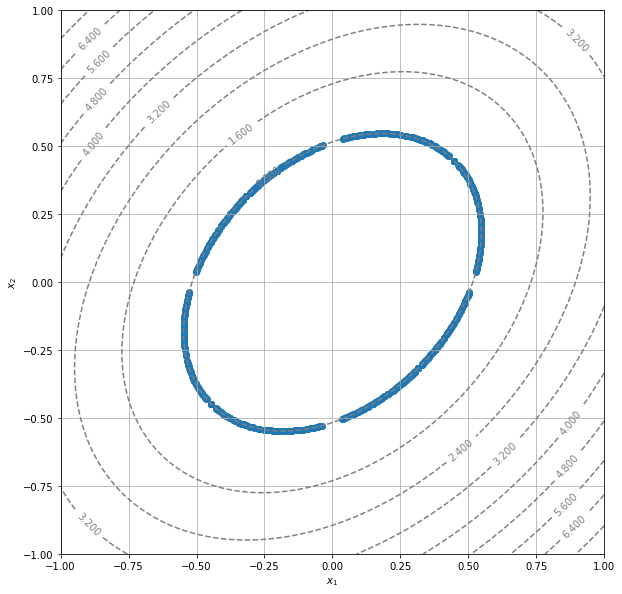

In [16]:
L = []
l, iterable = [-1, 1], list(range(1, 15))
l = list(product(l, l))
iterable = list(product(iterable, iterable))

for k, l in l:
    for i, j in iterable:
        def h(x, y): 
            return np.array([f1(x, y) - .8, i*x - k*l*j*y]) 
        L.append(Newton(h, k*.8, l*.8))

L = np.array(L)

def display_contour_test(f, x, y, levels, l):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)

    plt.scatter(l[:, 0], l[:, 1])

    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

display_contour_test(f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, 
    l=L)


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

**Réponse :**

Méthode :

- on part de $X_0 = (x_0, y_0)$, on calcule le gradient de $f$ en $X_0$, noté $\nabla f(X_0)$

- on normalise ce vecteur et on lui fait subir une rotation de $\frac{\pi}2$ pour se placer à droite

- on le dilate par $\delta$ afin d'être suffisamment éloigné

- on obtient le vecteur $X_{1'}$. On applique `Newton` en ce point : on *devrait* obtenir un point "proche"

etc.


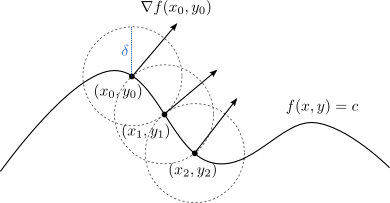

In [17]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
   values = [[x0, y0]]
   grad_f = grad(f) # gradient of f
   c = f(x0, y0)

   def f_bis(x, y):
      distance = (x-x0)**2 + (y - y0)**2 - delta**2
      return np.array([f(x, y) - c, distance]) 
   
   for k in range(N - 1):
      x0, y0 = values[k]
      grad_bis  = grad_f(x0, y0) # calcul gradient
      grad_bis /= np.linalg.norm(grad_bis, 2) # normalization
      grad_bis  = delta * np.dot(np.array([[0., 1.], [-1., 0.]]), grad_bis) # matrice de rotation de pi/2 et on multiplie par delta
      xbis, ybis = [x0, y0] + grad_bis
      values.append(Newton(f_bis, xbis, ybis, eps))  

   return np.array(values).T #we want that values.shape == (2, N)

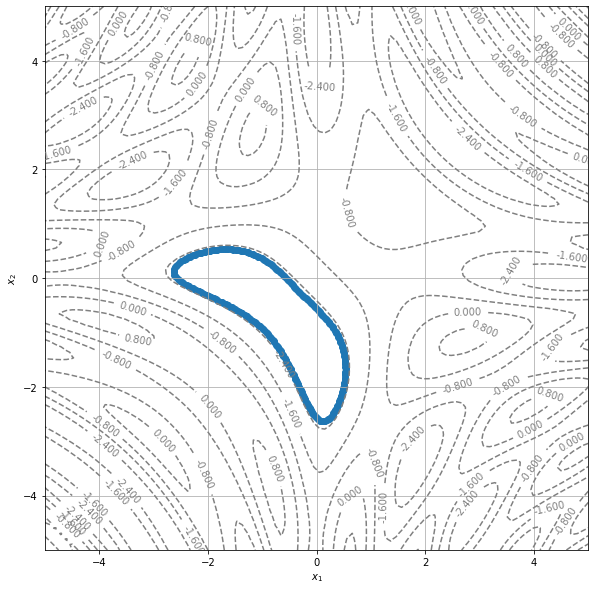

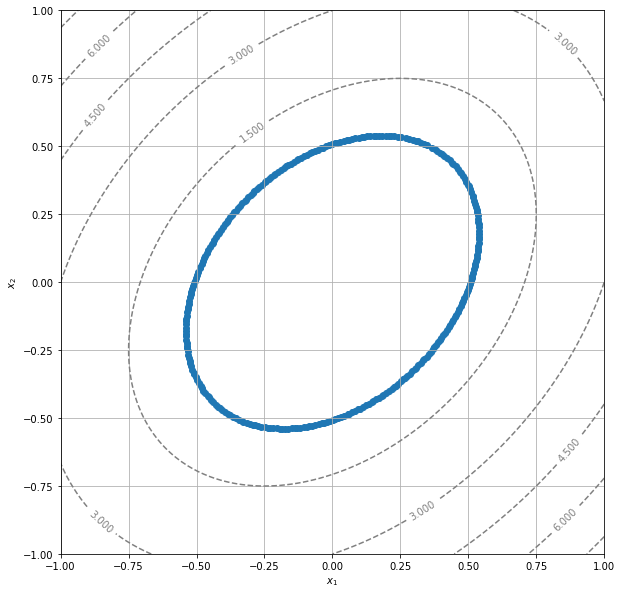

In [18]:
values = level_curve(f3, .5, -2., 0.1, 300)
values_bis = level_curve(f1, .44, .44, 0.1, 300)


def display_contour_bis(f, x, y, levels, V):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)

    plt.scatter(V[0, :], V[1, :])

    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")


display_contour_bis(f3,
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5,
    V=values)

display_contour_bis(f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100),
    levels=5,
    V=values_bis) 


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

**Réponse :**

Tout le problème est dans la fonction `intersection` qui permet de savoir si deux segments se coupent.

L'idée est de voir si trois points sont disposés en sens horaire ou anti-horaire. 

On implémente donc une fonction `anti_horaire` qui renvoie `True` si et seulement si les trois points en entrée sont disposés en sens anti-horaire.

Si les points $A, C, D$ et $B, C, D$ ne sont pas dans le même sens, et idem pour $A, B, C$ et $A, B, D$, alors il y a intersection des deux segments, et réciproquement.

In [19]:
def better_level_curve(f, x0, y0, delta = 0.1, eps = eps):
    values = [[x0, y0]]
    grad_f = grad(f) # gradient of f
    c = f(x0, y0)
    condition = True 

    def f_bis(x, y):
        distance = (x-x0)**2 + (y - y0)**2 - delta**2
        return np.array([f(x, y) - c, distance]) 

    
    def anti_horaire(A,B,C):
        '''
        returns True if A, B, C are ordered counter clockwise
        '''
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    def intersection(A,B,C,D):
        return anti_horaire(A,C,D) != anti_horaire(B,C,D) and anti_horaire(A,B,C) != anti_horaire(A,B,D)
        

    #first run
    grad_bis  = grad_f(x0, y0) # calcul gradient
    grad_bis /= np.linalg.norm(grad_bis, 2) # normalization
    grad_bis  = delta * np.dot(np.array([[0., 1.], [-1., 0.]]), grad_bis) # matrice de rotation de pi/2 et on multiplie par delta
    xbis, ybis = [x0, y0] + grad_bis
    values.append(Newton(f_bis, xbis, ybis, eps)) 
    X0, X1 = values[:2]

    while condition:
        x0, y0 = values[-1]
        grad_bis  = grad_f(x0, y0) # calcul gradient
        grad_bis /= np.linalg.norm(grad_bis, 2) # normalization
        grad_bis  = delta * np.dot(np.array([[0., 1.], [-1., 0.]]), grad_bis) # matrice de rotation de pi/2 et on multiplie par delta
        xbis, ybis = [x0, y0] + grad_bis
        values.append(Newton(f_bis, xbis, ybis, eps))
        Y0, Y1 = values[-2:]  
        if intersection(X0, X1, Y0, Y1):
            condition = False

    return np.array(values).T #we want that values.shape == (2, N)

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

**Réponse :**

Cela fonctionne correctement comme en témoigne ce qui suit.

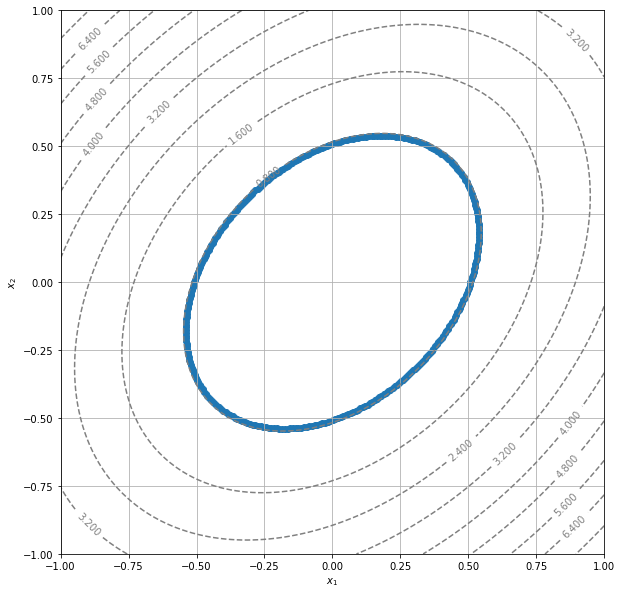

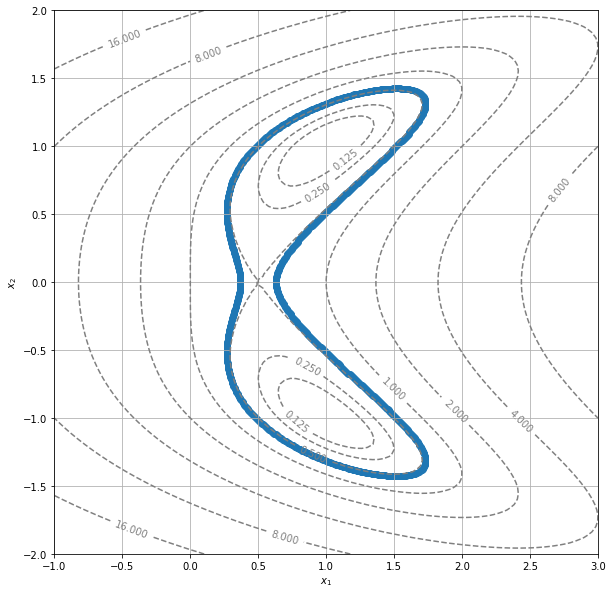

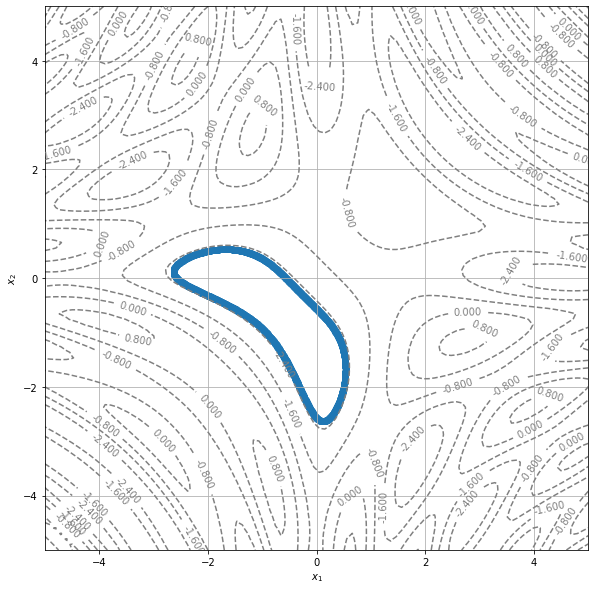

In [20]:
def display_contour_ter(f, x, y, levels, x0, y0, delta=.01, N = 200):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)

    values = better_level_curve(f, x0, y0, delta, N)
    plt.scatter(values[0, :], values[1, :])

    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
   
display_contour_ter(f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100),
    levels=10,
    x0=.44,
    y0=.44,)

display_contour_ter(f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)], 
    x0=.3, 
    y0=.3,
)

display_contour_ter(f3,
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5,
    x0=.5,
    y0=-2.
)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

**Réponse :**

On pose :
$\begin{cases}
P_1 = (g,h) \\ P_2 = (i,j) \\ u_1 = (k,l) \\ u_2 = (m,n)
\end{cases}$


*Analyse* :

1. $\gamma(0)=(a,d)=P_1, $ 
1. $\gamma(1)=(a+b+c,d+e+f)=P_2 $ 
1. $\gamma'(0)=\lambda*u_1=(b,e)$ où $ \lambda \in \mathbb{R}_+^* $ (car même sens, le $\lambda \ne 0$ dépend de l'interprétation)
1. $\gamma'(1)=\lambda'*u_2=(b+2c,e+2f)$ où $ \lambda' \in \mathbb{R}_+^* $

On obtient ainsi un système de 8 équations pour 8 inconnues (6 inconnues + 2 paramètres) qui se résout en :
1. $ a = g $ et $ d = h$
1. $ b+c = i-g $ et $ e+f = j-h $
1. $ b = \lambda k $ et $ e = \lambda l $
1. $ b+2c = \lambda'm $ et $ e+2f = \lambda'n$

4) et 3) donnent 
$  2(b+c)-\lambda k = \lambda'm $

D'où par 2)
\begin{equation}
(1) : \   2(i-g)-\lambda k = \lambda'm 
\end{equation}


Le même raisonnement donne 

\begin{equation}
(2) : \ 2(j-h)-\lambda l = \lambda'n 
\end{equation}


(1) donne alors $\lambda k = 2(i-g)-\lambda'm$.


On a donc $\lambda kn = 2n(i-g) - m[2(j-h)-\lambda l]$

Puis $\lambda (kn-lm) = 2[n(i-g)-m(j-h)] : (*)$

D'où $\lambda (kn-lm)^2 = 2(kn-lm)[n(i-g)-m(j-h)]$

Puisque $\lambda \geq 0 $ on a la condition $ (kn-lm)[n(i-g)-m(j-h)] \geq 0$


Soit $ (u_1 \wedge u_2)[u_2 \wedge (P_2-P_1)] \geq 0 $

On remarque dans $(*)$ que $u_1 // u_2 \Leftrightarrow (P_2-P_1) // u_2$


*Remarque* : Le même raisonnement sur $\lambda'$ conduit au même résultat. 

* 1er cas : $u_1 // u_2$. 
 * 1er sous-cas : $P_2-P_1$ non colinéaire à $u_2$ (et $u_1$).Pas de solution.
 * 2ème sous-cas : $(P_2-P_1)$ // $u_2$ (et $u_1$)

On pose a alors $(\alpha ,\beta) \in (\mathbb{R}^*)^2 $ tel que :
$\begin{cases}
i-g =\alpha k \\
j-h =\alpha l \\
m = \beta k \\
n = \beta l
\end{cases}$

$(*)$ donne alors $0=0$ (perte d'une équation) et puisque $u_1 \neq 0$, on a $k \neq 0$ ou $l \neq 0$. Grâce à $(1)$ ou $(2)$ on obtient $\lambda = 2 \alpha - \beta \lambda'$
  * 1er sous-sous cas : $\alpha > 0$
Alors on peut choisir $\lambda'>0$ suffisament petit tel que $\lambda >0$
  * 2ème sous-sous cas : $\alpha < 0$
   * 1er sous-sous-sous cas : $\beta >0$. Pas de solution.
   * 2ème sous-sous-sous cas : $\beta <0$. Alors pour $\lambda'>0$ assez grand, on aura $\lambda>0$
 
Dans les cas où des solutions existent, il y en a une infinité (de paramètre $\lambda'$)

On aura alors 
$\begin{cases}
b = (2\alpha-\beta \lambda')u_{1,x} \\
c = (\beta \lambda'-\alpha)u_{1,x} \\
e = (2\alpha-\beta \lambda')u_{1,y} \\
f = (\beta \lambda'-\alpha)u_{1,y} \\
\end{cases}$

* 2ème cas : $u_1$ non colinéaire à $u_2$.
 * 1er sous-cas : $ (u_1 \wedge u_2)[u_2 \wedge (P_2-P_1)]< 0 $ ou $ (u_1 \wedge u_2)[u_1 \wedge (P_2-P_1)]< 0 $ . Pas de solution.
 * 2ème sous-cas : $ (u_1 \wedge u_2)[u_2 \wedge (P_2-P_1)] \geq 0 $ et $ (u_1 \wedge u_2)[u_1 \wedge (P_2-P_1)] \geq 0 $ :

Alors $ \lambda = 2\frac{n(i-g)-m(j-h)}{kn-lm} = \frac{u_2 \wedge (P_2-P_1)}{u_1 \wedge u_2}$

Par symétrie on a $\lambda' = \frac{u_1 \wedge (P_2-P_1)}{u_1 \wedge u_2}$

On aura alors 
$\begin{cases}
b = 2\frac{u_2 \wedge (P_2-P_1)}{u_1 \wedge u_2}u_{1,x} \\
c = (P_2-P_1)_x-2\frac{u_2 \wedge (P_2-P_1)}{u_1 \wedge u_2}u_{1,x}\\
e = 2\frac{u_1 \wedge (P_2-P_1)}{u_1 \wedge u_2}u_{1,y}\\
f = (P_2-P_1)_y-2\frac{u_1 \wedge (P_2-P_1)}{u_1 \wedge u_2}u_{1,y}
\end{cases}$

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [21]:
def gamma(t, P1, P2, u1, u2):
    u1 = np.array(u1)
    u2 = np.array(u2)
    P1 = np.array(P1)
    P2 = np.array(P2)
    a, d = P1

    def rectiligne(t):
        return np.array([(P2[0] - P1[0])*t, (P2[1] - P1[1])*t]) 

    if np.cross(u1, u2) == 0. : # u1 colinéaire à u2
        if np.cross(P2-P1, u1) != 0.: 
            return rectiligne(t)
        if u1[0] != 0.:
            alpha = (P2-P1)[0]/u1[0]
            beta  = u2[0]/u1[0]
        else : # Alors nécéssairement u1[1]!=0
            alpha = (P2-P1)[1]/u1[1]
            beta  = u2[1]/u1[1]
        if alpha < 0. and beta > 0.:
            return rectiligne(t)
        elif alpha < 0. and beta < 0.:
            Lambda_prim = 1
            Lambda = 2.*alpha - beta*Lambda_prim # lambda variable qui existe déjà
            while Lambda < 0.:
                Lambda_prim+=1.
                Lambda = 2.*alpha-beta*Lambda_prim
        elif alpha > 0.:
            Lambda_prim = 0.5
            Lambda = 2.*alpha-beta*Lambda_prim
            while Lambda < 0.:
                Lambda_prim /= 2.
                Lambda = 2.*alpha - beta*Lambda_prim
    else : 
        if np.cross(u1,u2)*np.cross(u1,P2-P1)<0. or np.cross(u1,u2)*np.cross(u2,P2-P1)<0. : #On doit avoir lambda > 0 et lambda' > 0
            return rectiligne(t)
        else : 
            Lambda = np.cross(u1, u2)*np.cross(u2, P2 - P1)
    b, e = Lambda*u1
    c, f = (P2 - P1) - (b, e)
    return np.array([a + b*t + c*t**2, d + e*t + f*t**2])


### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [22]:
def level_curve_os(f, x, y, levels, x0, y0, oversampling, delta=.1, N = 200):
    grad_f = grad(f)
    if oversampling == 1:
        return better_level_curve(f, x0, y0), None
    else:  # on considère que de toute façon, oversampling >= 1
        values = better_level_curve(f, x0, y0, delta)
        values_ter = []
        T = np.linspace(0, 1, oversampling - 1)
        for i in range(len(values[1]) - 1):
            point = values[:, i]
            point_2 = values[:, i+1]
            local_partial = grad(f3)(point[0], point[1])
            local_partial_2 = grad(f3)(point_2[0], point_2[1])
            values_bis = gamma(T, point, point_2, local_partial, local_partial_2)
            values_ter.append(values_bis[:, 1:-1])
        values_ter = np.array(values_ter).T

        return values, values_ter


#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

**Réponse :**

Ça fonctionne assez bien, excepté le fait que l'on a des "anomalies" : des points hors de la courbe de niveau ...

In [23]:
def display_contour_os(f, x, y, levels, x0, y0, oversampling, delta=.05, N=100):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)

    values, values_ter = level_curve_os(f, x, y, levels, x0, y0, oversampling, delta, N)
    plt.scatter(values[0, :], values[1, :], color = 'steelblue')
    plt.scatter(values_ter[:, 0], values_ter[:, 1], color = 'steelblue')

    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
   

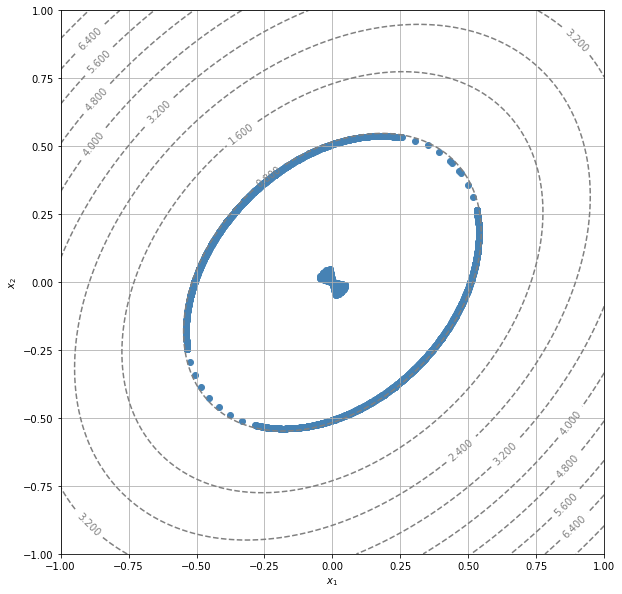

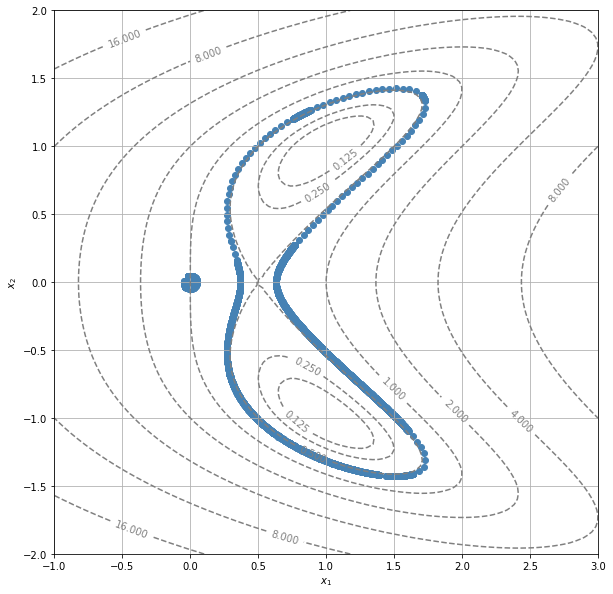

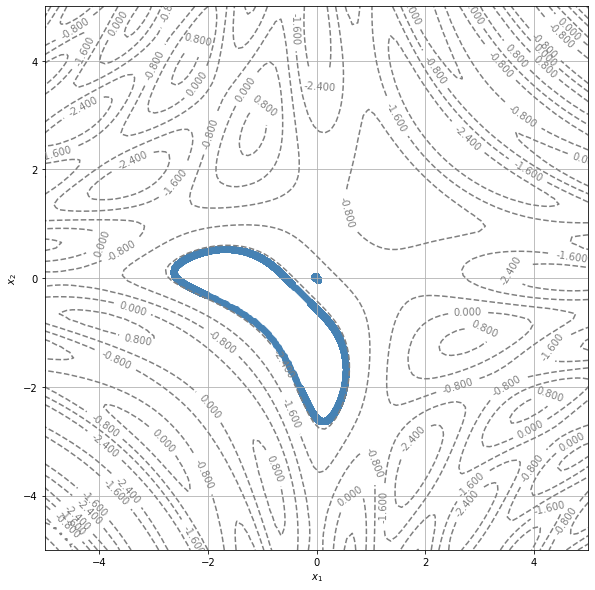

In [24]:
display_contour_os(f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100),
    levels=10,
    x0=.44,
    y0=.44,
    oversampling=50
)

display_contour_os(f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)], 
    x0=.3, 
    y0=.3,
    oversampling=50
)

display_contour_os(f3,
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5,
    x0=.5,
    y0=-2.,
    oversampling=50
)